<a href="https://colab.research.google.com/github/H-Seung/Section4-Project/blob/main/AI_16_%ED%95%9C%EC%8A%B9%ED%9D%AC_Section4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Setup

In [1]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import Image
from tqdm import tqdm
import json
import yaml
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 15064, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 15064 (delta 22), reused 26 (delta 11), pack-reused 15019
Receiving objects: 100% (15064/15064), 14.13 MiB | 23.68 MiB/s, done.
Resolving deltas: 100% (10315/10315), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.0 MB/s eta 0:00:00


In [3]:
import torch
from IPython.display import Image, clear_output
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.13.1+cu116 (CPU)


# 2) Load the data & Transfer COCO to Yolo format

### 데이터 업로드 (디렉토리 세팅 포함)

In [4]:
%cd ../

/content


In [5]:
# # 샘플데이터 업로드

# # 로컬에서 파일 업로드
# from google.colab import files
# uploaded = files.upload()

In [6]:
# os.mkdir('/content/sample_dataset')
# !unzip -qq '/content/sample.zip' -d '/content/yolov5/sample_dataset'

In [7]:
# # 구글 드라이브 연동 오류 관련 
# !sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !sudo apt-get update -qq 2>&1 > /dev/null
# !sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
# !google-drive-ocamlfuse


^C


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offl

In [8]:
# !sudo apt-get install -qq w3m # to act as web browser 
# !xdg-settings set default-web-browser w3m.desktop # to set default browser
# %cd /content
# !mkdir drive
# %cd drive
# !mkdir MyDrive
# %cd ..
# %cd ..
# !google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 129501 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
^C
[Errno 2] No such file or directory: 'drive'
/content
/
/
Error: Mountpoint /content/drive/MyDrive should be an existing directory.


In [15]:
# 실제데이터 업로드

# Google Drive 에서 불러오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
os.mkdir('/content/yolov5/dataset')

In [16]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/dataset_traffic.zip' -d '/content/yolov5/dataset'

train, test 이미지 파일들의 경로 리스트를 txt 파일로 저장

In [17]:
from glob import glob

train_img_list = glob('/content/yolov5/dataset/images/train/*.jpg')
valid_img_list = glob('/content/yolov5/dataset/images/validation/*.jpg')
print(len(train_img_list),len(valid_img_list))

22177 7400


In [18]:
# txt 파일로 위 변수 리스트 저장

with open('/content/yolov5/dataset/train.txt', 'w') as f:
    f.write('\n'.join(train_img_list) + '\n')

with open('/content/yolov5/dataset/val.txt', 'w') as f:
    f.write('\n'.join(valid_img_list) + '\n')

### Json 파일을 Yolo Format으로 변환

In [19]:
json_path_list = glob('/content/yolov5/dataset/labels/*/*.json')
len(json_path_list) # json 파일 개수 확인

29577

In [ ]:
# json 파일의 내용 형태 확인
# import pprint

# tmp = []
# for json_path in json_path_list[:2]:
#     print(json_path)
#     with open(json_path, "r") as jsondata:
#         json_data = json.load(jsondata)
#     tmp.append(json_data)
# pprint.pprint(tmp[0])
# pprint.pprint(tmp[1])

In [ ]:
def convert(size, box): #box: coco형식 xmin , ymin , w , h
    dw = 1/size[0]
    dh = 1/size[1]
    w = box[2]-box[0]
    h = box[3]-box[1]
    x = box[0]+ w/2
    y = box[1]+ h/2
    x = round(x*dw,6)
    w = round(w*dw,6)
    y = round(y*dh,6)
    h = round(h*dh,6)
    if w <0 or h < 0:
        return False
    return (x,y,w,h)

In [ ]:
os.mkdir('/content/yolov5/dataset/json_labels/')

In [ ]:
size = [1280,720]
class_names = []
for json_path in tqdm(json_path_list):
    with open(json_path, "r") as f:
        json_data = json.load(f)
    label_path = json_path.replace('.json','.txt')
    # img_path = json_path.replace('/labels','/images').replace('.json','.jpg') # 확인용
    # img = Image(img_path)
    # display(img)

    for d in json_data["annotation"]:
        box = d['box']
        bb = convert(size, box) # x0,y0,x1,y1 to x,y,w,h
        if bb==False:
            continue

        cls = d['class']
        if cls not in class_names:
            class_names.append(cls)

        line = f'{class_names.index(cls)} {bb[0]} {bb[1]} {bb[2]} {bb[3]}\n'
        with open(label_path, 'a') as f:
            f.write(line)
        
    shutil.move(json_path, '/content/yolov5/dataset/json_labels') # json 파일은 다른 폴더로 이동

label_path_list = glob("/content/yolov5/dataset/labels/*/*.txt")
print(f'변환후 label 파일(txt) 개수 : {len(label_path_list)}') # no objects in image, no *.txt file


100%|██████████| 29577/29577 [00:08<00:00, 3408.72it/s]


변환후 label 파일(txt) 개수 : 26998


In [ ]:
class_names

['traffic_sign', 'traffic_light', 'traffic_information']

In [ ]:
len(glob("/content/yolov5/dataset/labels/*/*.json")) 

0

In [ ]:
# 변환됐는지 확인
with open(label_path, "r") as f:
    while True:
        ln = f.readline()
        if not ln:
            break
        print(ln)

0 0.602734 0.234722 0.013281 0.022222

0 0.642969 0.285417 0.0125 0.020833

1 0.579688 0.253472 0.01875 0.0125

1 0.626563 0.255556 0.01875 0.016667



# 3) yaml 파일 만들기


In [ ]:
# Create dataset.yaml file 
yaml_dict = {'train': './dataset/images/train/',   # path to the train folder
            'val': './dataset/images/validation/', # path to the val folder
            'nc': 3,                             # number of classes
            'names': ['traffic_sign', 'traffic_light', 'traffic_information']}     # list of label names

# we will make the file under the yolov5/data/ directory.
data_yaml = '/content/yolov5/dataset/dataset.yaml'
with open(data_yaml, 'w') as f:
    yaml.dump(yaml_dict, f, default_flow_style=True)

In [ ]:
%cat '/content/yolov5/dataset/dataset.yaml' # show your YAML file

{names: [traffic_sign, traffic_light, traffic_information], nc: 3, train: ./dataset/images/train/,
  val: ./dataset/images/validation/}


In [ ]:
# # 다른 방법

# # 사용할 데이터셋 경로 및 데이터셋의 yaml 파일 경로 지정
# data_dir = '/content/dataset'
# data_yaml = '/content/dataset/dataset.yaml'

# # 데이터셋 yaml 파일 확인 
# with open(data_yaml) as f:
#     film = yaml.load(f, Loader=yaml.FullLoader)
#     display(film)

In [ ]:
# # yaml 파일의 train, val 데이터가 있는 경로 수정 (기존 경로 -> 구글 드라이브에 저장된 경로로)
# film['train'] = '/content/dataset/train/images'
# film['val'] = '/content/dataset/validation/images'

# with open(data_yaml, 'w') as f:
#     yaml.dump(film, f)

# print('변경된 yaml 파일 :')
# with open(data_yaml) as f:
#     film = yaml.load(f, Loader=yaml.FullLoader)
#     display(film)

# 4) 모델 구성
 nc 부분만 바꾸어주었음

In [ ]:
from IPython.core.magic import register_line_cell_magic

# 템플릿 문서들을 python에서 쓸 수 있도록 함수 생성
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml # 해당 모델 출력하기

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
# 위 출력 결과를 수정
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat /content/yolov5/models/custom_yolov5s.yaml # 확인


# Parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, Fa

# 5) 모델 학습

In [ ]:
!pip install -q --upgrade wandb
# Login 
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.7 MB/s eta 0:00:00


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%cd /content/yolov5/

/content/yolov5


* --img {IMG_SIZE} \ # Input image size.
--batch {BATCH_SIZE} \ # Batch size
--epochs {EPOCHS} \ # Number of epochs
--data data.yaml \ # Configuration file
--cfg # 모델 yaml 파일
--weights yolov5s.pt \ # Model name 전이학습 사용시에 쓸 weight
--save_period 1\ # Save model after interval
--project yolov5-traffic # W&B project name
--name exp # experiment name. runs 폴더안에 저장할 파일이름
--cache: 빠른 학습을 위한 이미지 캐시

In [ ]:
%time
!python train.py --img 480 \
                 --batch 32\
                 --epochs 5\
                 --data ./dataset/dataset.yaml\
                 --cfg ./models/custom_yolov5s.yaml\
                 --weights ''\
                 --project yolov5-traffic\
                 --save-period 1\
                 --name traffic_results\
                #  --cache

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: ggdd55440. Use `wandb login --relogin` to force relogin
train: weights=, cfg=./models/custom_yolov5s.yaml, data=./dataset/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=32, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5-traffic, name=traffic_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yol

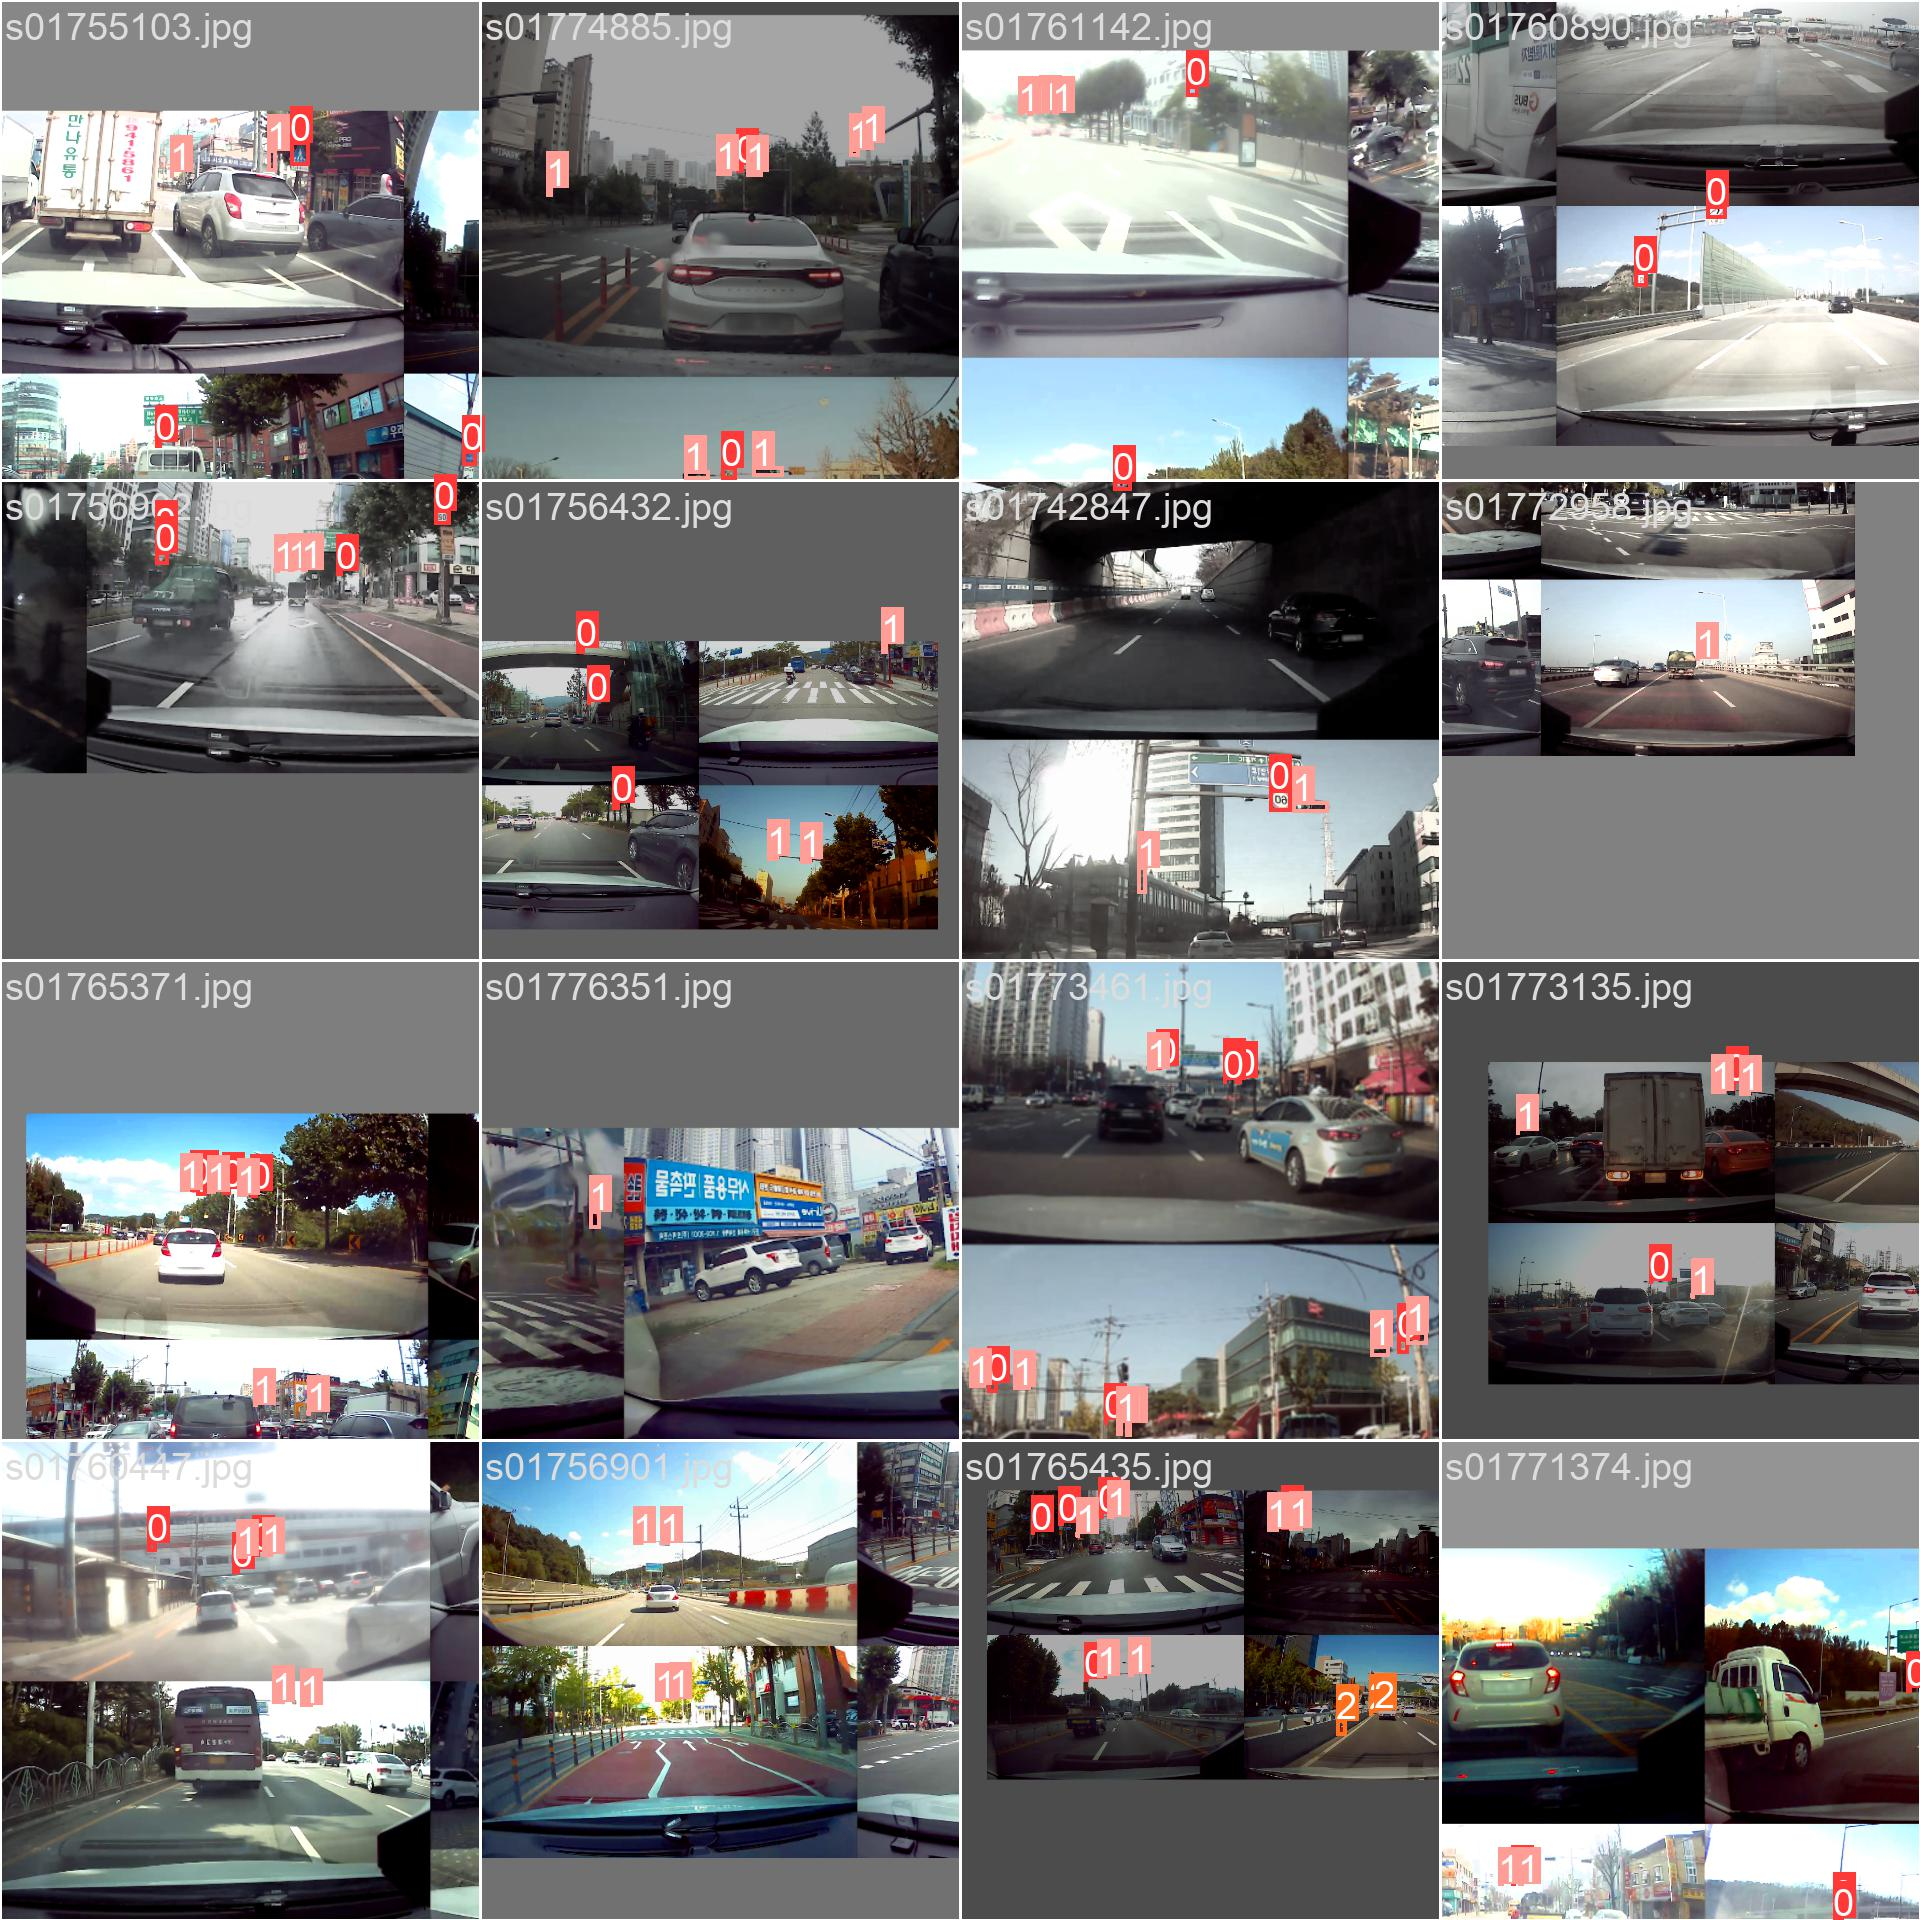

In [ ]:
Image(filename='/content/yolov5/yolov5-traffic/traffic_results/train_batch0.jpg', width=1000)

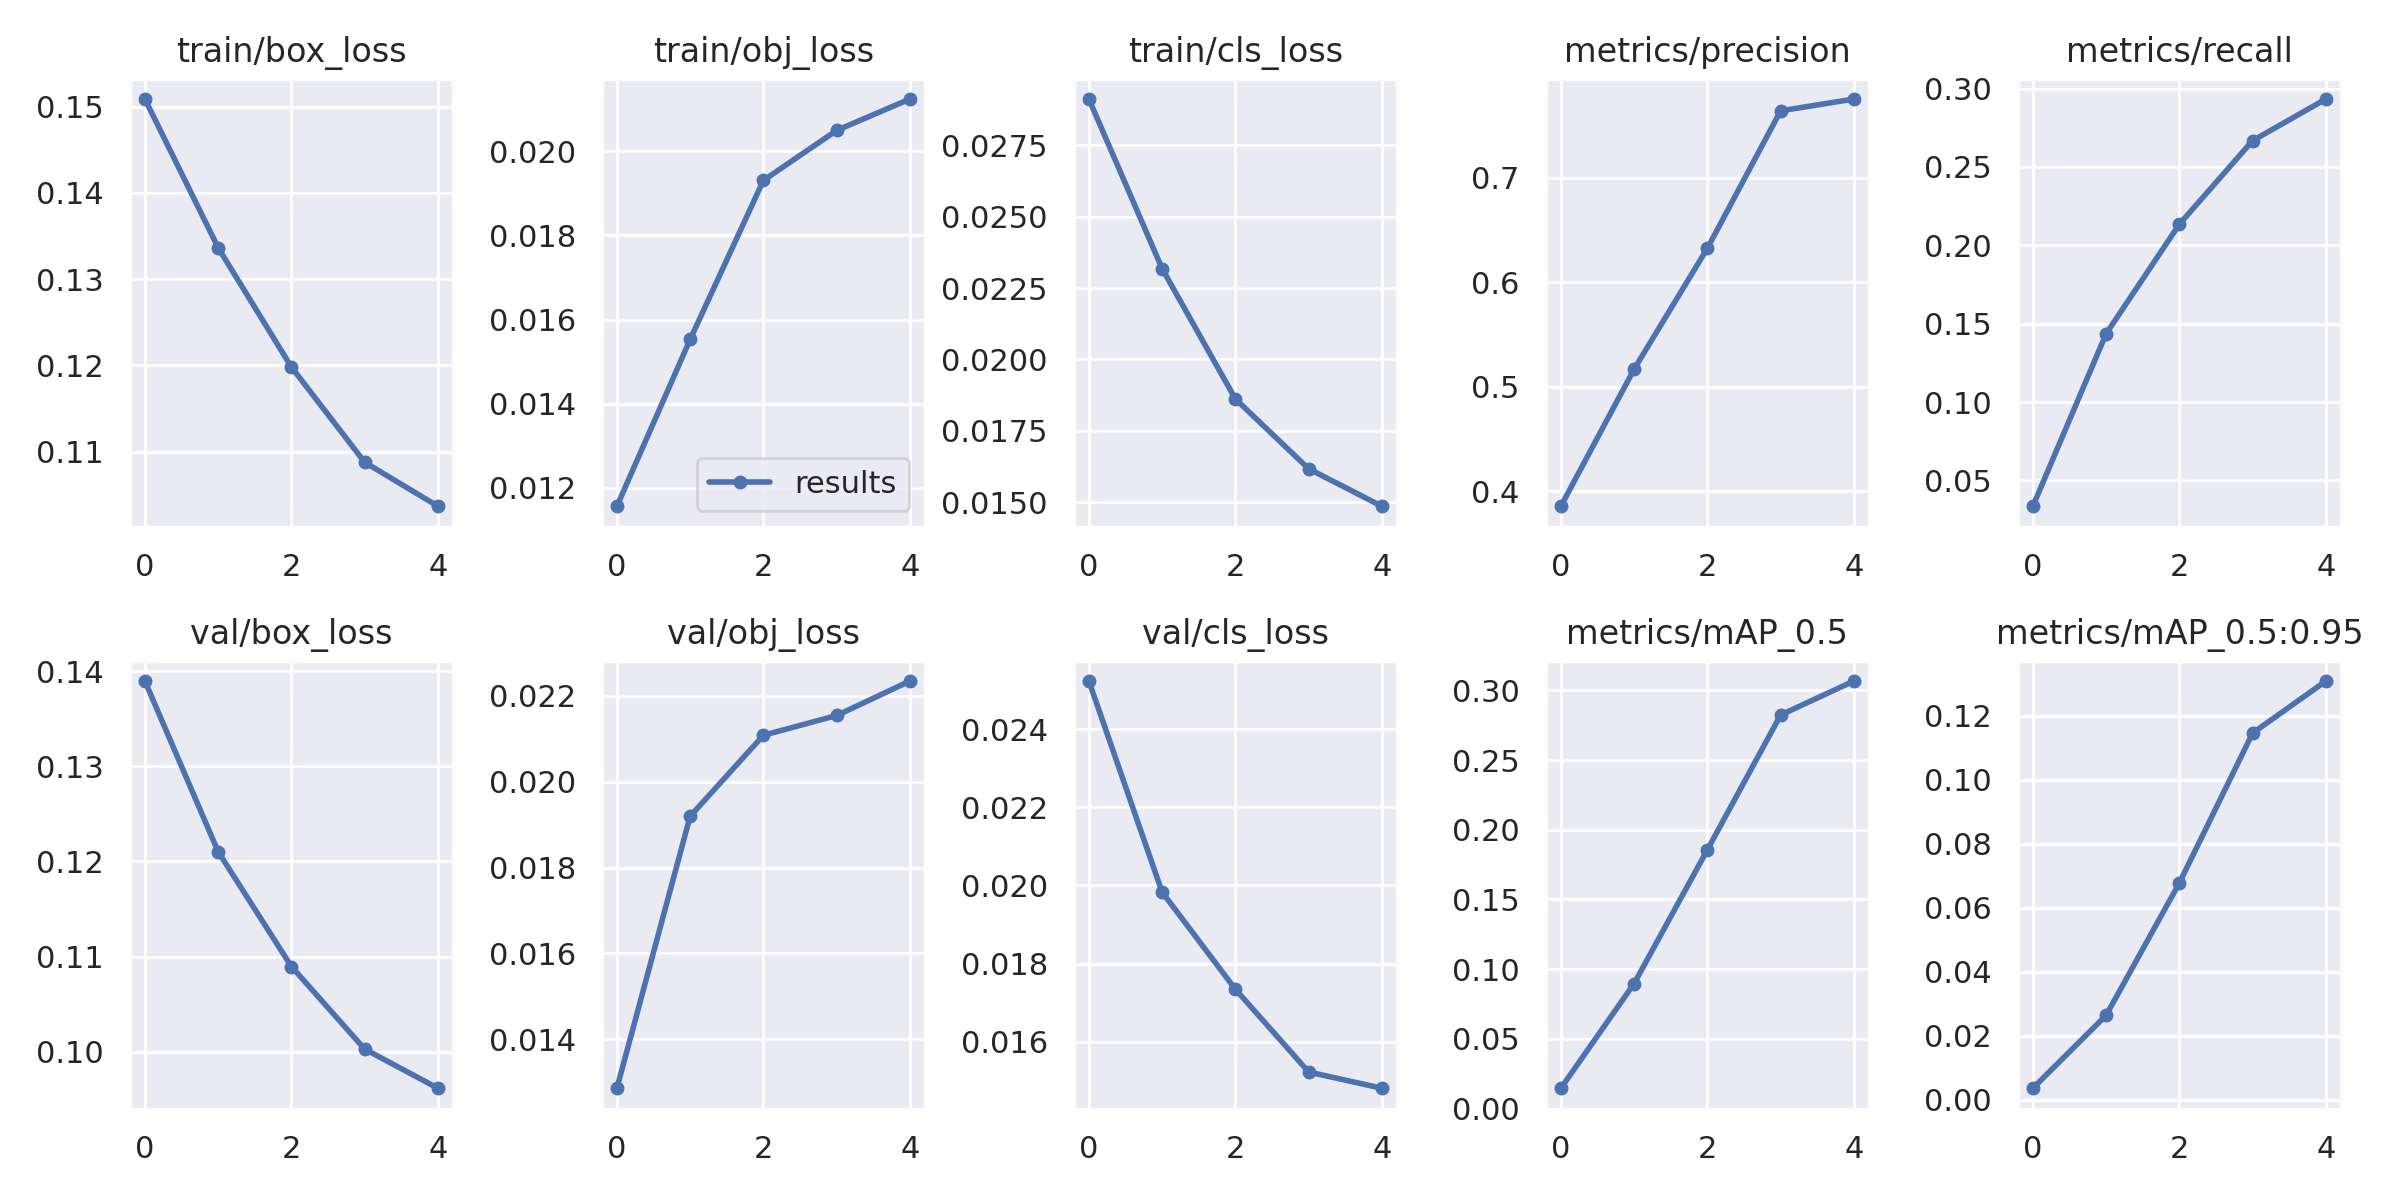

In [ ]:
Image(filename='/content/yolov5/yolov5-traffic/traffic_results/results.png', width=1000)

### [wandb 리포트](https://api.wandb.ai/links/ggdd55440/sdq1xedq)

# 6) 모델 테스트 (Inference)

* --weights {MODEL_PATH} \ # path to the best model.
--source {TEST_PATH} \ # absolute path to the test images.
--img {IMG_SIZE} \ # Size of image
--conf 0.25 \ # Confidence threshold (default is 0.25)
--iou-thres 0.45 \ # IOU threshold (default is 0.45)
--max-det 100 \ # Number of detections per image (default is 1000)
--save-txt \ # Save predicted bounding box coordinates as txt files
--save-conf # Save the confidence of prediction for each bounding box
--augment # augmented inference, TTA
--project 'runs/detect' # save results to project/name
--name 'exp' # save results to project/name
--half False # use FP16 half-precision inference

In [ ]:
# 테스트 이미지 경로
test_data_dir = '/content/yolov5/dataset/images/validation/'

# 실험 번호 지정 - 진행한 실험이 저장된 경로 확인해서 기입
train_exp_num = ''

In [ ]:
!python detect.py --weights /content/yolov5/yolov5-traffic/traffic_results{train_exp_num}/weights/best.pt \
                  --img 480 \
                  --conf 0.1 \
                  --source {test_data_dir} \
                  --save-txt \
                  --save-conf

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
image 2404/7400 /content/yolov5/dataset/images/validation/s01743515.jpg: 288x480 3 traffic_signs, 7.6ms
image 2405/7400 /content/yolov5/dataset/images/validation/s01743516.jpg: 288x480 (no detections), 7.7ms
image 2406/7400 /content/yolov5/dataset/images/validation/s01743517.jpg: 288x480 1 traffic_sign, 5 traffic_lights, 8.1ms
image 2407/7400 /content/yolov5/dataset/images/validation/s01743518.jpg: 288x480 (no detections), 7.9ms
image 2408/7400 /content/yolov5/dataset/images/validation/s01743519.jpg: 288x480 1 traffic_sign, 1 traffic_light, 8.0ms
image 2409/7400 /content/yolov5/dataset/images/validation/s01743520.jpg: 288x480 3 traffic_signs, 8 traffic_lights, 7.6ms
image 2410/7400 /content/yolov5/dataset/images/validation/s01743521.jpg: 288x480 2 traffic_signs, 1 traffic_light, 8.9ms
image 2411/7400 /content/yolov5/dataset/images/validation/s01743522.jpg: 288x480 1 traffic_sign, 17.5ms
image 2412/7400 /content/yolov5/dataset/images/validation/s01743

### visualize our prediction

In [ ]:
with open('/content/yolov5/runs/detect/exp3/labels/s01070713.txt', 'r') as file:
    for line in file:
        print(line)
# class number, epoch별 iou

0 0.566406 0.685417 0.028125 0.0430556 0.143862

1 0.513672 0.698611 0.0304688 0.0194444 0.682103

1 0.608594 0.715972 0.0328125 0.0208333 0.857116



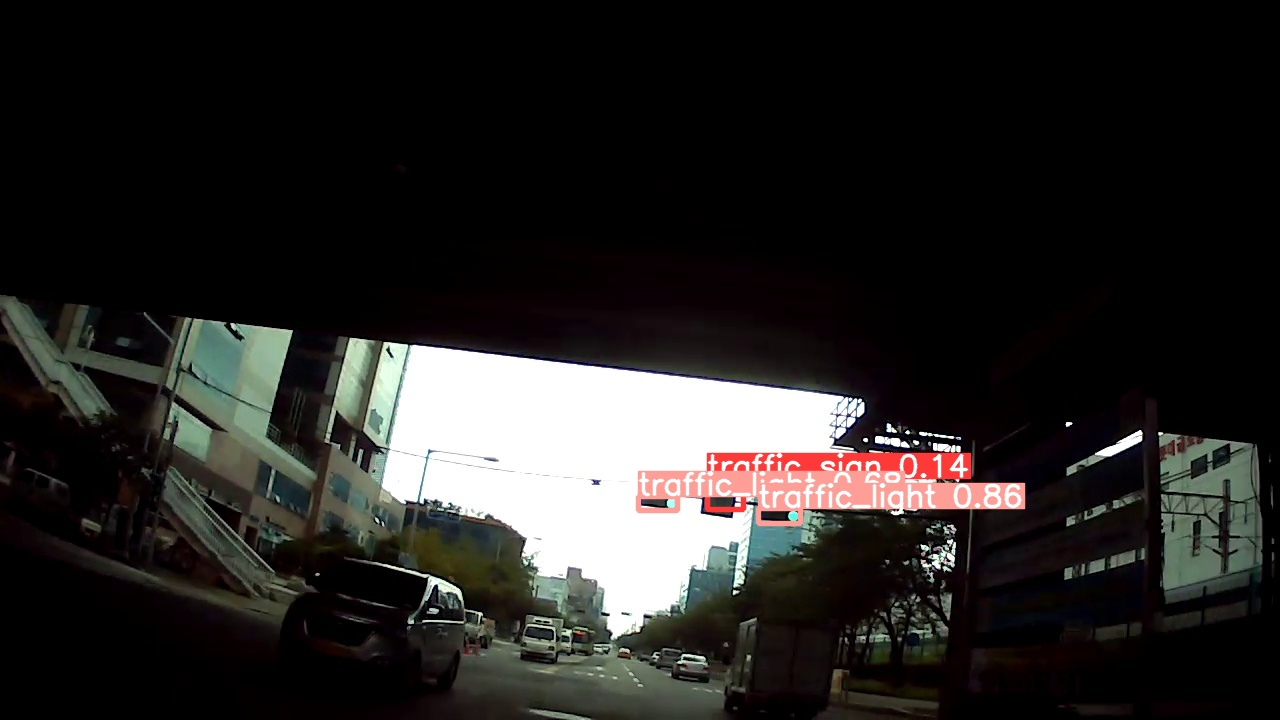

In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

# for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
#     display(Image(filename=imageName))
#     print("\n")

image_name = '/content/yolov5/runs/detect/exp3/s01070713.jpg'
display(Image(filename=image_name))

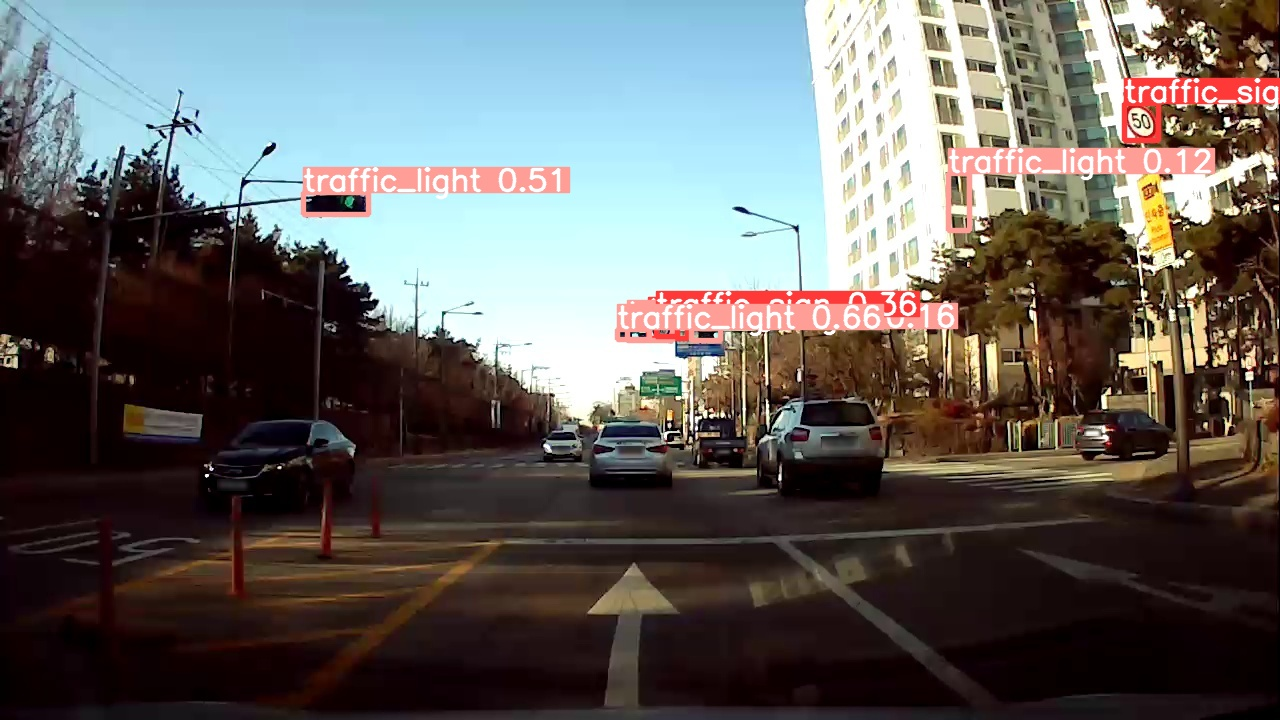

In [ ]:
image_name = np.random.choice(glob.glob('runs/detect/exp3/*.jpg')) # 랜덤으로 하나만 출력
display(Image(filename=image_name))

# 7) 학습한 모델 내보내기

In [ ]:
%mkdir /content/drive/MyDrive/traffic_project/
%cp /content/yolov5/yolov5-traffic/traffic_results{train_exp_num}/weights/best.pt /content/drive/MyDrive/traffic_project/